The `jaywalking_comparison_analysis.ipynb` notebook, located in the code/ directory, performs a comparative analysis of jaywalking incidents across different datasets. The analysis includes data from Virginia and Denver, as indicated by the variables `virginia_df` and `denver_gdf`.

### Key Components:
1. **Data Loading and Preparation**:
   - The notebook reads various datasets, including CSV and GeoJSON files, to create dataframes for analysis.
   - Example datasets include `CrashData_test_6478750435646127290.csv` and `Traffic_Accidents_(Offenses).geojson`.
   - Further transformations are performed to capture information on intervention (decriminalization or legalization of jaywalking) and incident counts.
    - T (Month)	- counting up from 0 for the earliest entry then continuing 1,2,3,etc
    - D (Intervention)	- 0 if the intervention has not taken place yet and 1 if it has
    - P (Intervention month) - number of months since intervention

2. **Data Analysis**:
   - The analysis includes aggregating incident counts by month and year, as shown in the excerpt:
     ```plaintext
     month  year  total_incidents  total_pedestrian_incidents
     1      2013  1855             68
     2      2013  1571             42
     ...
     3      2024  1431             37
     ```
   - The notebook calculates the percentage of pedestrian incidents relative to total incidents.

3. **Modeling and Statistical Analysis**:
   - The notebook creates two models for each dataset: one which contains T, D, and P and is trained on the full dataset, and another (the counterfactual) which contains only T and is trained on the dataset up to the intervention.
   - The results are then graphed to show the relationship between the intervention and pedestrian incidents, and the counterfactuals show the expected number of incidents if the intervention had not taken place.
     

### Observations:
#### Denver:
- Pedestrian-Vehicle Crashes / Total Crashes each month
    - Small (less than 1%) statistically significant increase in pedestrian involved crashes each month and the amount of months since jaywalking was decriminalized 
-  Non-Intersection Pedestrian-Vehicle Crashes / Total Crashes each month
     - No statistically significant relationship between decriminalization and non-intersection pedestrian crashes  

#### Virginia Beach:
- Pedestrian-Vehicle Crashes / Total Crashes each month
     - Small (less than 1%) statistically significant increase in pedestrian involved crashes each month and the amount of months since jaywalking was legalized, but also small (less than 1%) statistically significant decrease in pedestrian involved crashes each month and whether jaywalking was legal that month
- Non-Intersection Pedestrian-Vehicle Crashes / Total Crashes each month
     - No statistically significant relationship between decriminalization and non-intersection pedestrian crashes  

### Recommendations:
- Further transform the data to improve results and distribution of residuals.
- Rerun the analysis in R and compare the results to ensure consistency and accuracy.




# Import Libraries

In [26]:
import requests
import pandas as pd
import json
import geopandas as gpd
import re
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Denver

## Read in data

In [106]:
# https://drive.google.com/file/d/1F5--R6Gz2B1w7HNlR55RzErPHojYvIWG/view?usp=drive_link
denver_gdf = gpd.read_file("../data/input/Traffic_Accidents_(Offenses).geojson")

In [8]:
denver_gdf

,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,...,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,geometry
0,211522192,2022187347,202218734754010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-04-15 23:00:00+00:00,2022-04-15 16:00:00+00:00,2022-04-15 18:19:00+00:00,1900 BLOCK CHESTNUT PL,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,POINT (-104.99965 39.75669)
1,211522193,2022344975,202234497554410,5441,0,TRAF - ACCIDENT,2022-07-07 20:50:00+00:00,2022-07-07 13:50:00+00:00,2022-07-07 13:52:00+00:00,E 49TH AVE / N HAVANA ST,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.86585 39.78675)
2,211522194,2022345001,202234500154410,5441,0,TRAF - ACCIDENT,2022-07-07 21:03:00+00:00,2022-07-07 14:03:00+00:00,2022-07-07 15:58:00+00:00,8000 E EASTMAN AVE,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.89562 39.65819)
3,211522195,2022345039,202234503954410,5441,0,TRAF - ACCIDENT,2022-07-07 21:22:00+00:00,2022-07-07 14:22:00+00:00,2022-07-07 15:16:00+00:00,1700 BLOCK N SHERIDAN BLVD,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-105.05276 39.74443)
4,211522196,2022318139,202231813954410,5441,0,TRAF - ACCIDENT,2022-06-23 21:28:00+00:00,2022-06-23 14:28:00+00:00,2022-06-23 14:28:00+00:00,S SANTA FE DR / W ALAMEDA AVE,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.99714 39.71119)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252252,211774444,2022219486,202221948654010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-05-02 20:50:00+00:00,2022-05-02 13:50:00+00:00,2022-05-02 18:30:00+00:00,N COLORADO BLVD / E 23RD AVE,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,POINT (-104.94062 39.75104)
252253,211774445,2022174012,202217401254412,5441,2,TRAF - ACCIDENT - FATAL,2022-04-09 02:00:00+00:00,2022-04-08 19:00:00+00:00,2022-04-08 19:56:00+00:00,E COLFAX AVE / N RACE ST,...,OTHER,0.0,1.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.96347 39.73999)
252254,211774446,20225001248,2022500124854410,5441,0,TRAF - ACCIDENT,2022-04-12 18:07:00+00:00,2022-04-12 11:07:00+00:00,2022-04-12 11:07:00+00:00,TEST,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,None
252255,211774447,2022195838,202219583854010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-04-20 16:30:00+00:00,2022-04-20 09:30:00+00:00,2022-04-20 10:39:00+00:00,1375 N WASHINGTON ST,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,POINT (-104.97906 39.73821)


## Data Cleaning

In [107]:
denver_gdf['occurrence_date'] = pd.to_datetime(denver_gdf['first_occurrence_date'])

In [108]:
# Create a new column for month and year
denver_gdf['month'] = denver_gdf['occurrence_date'].dt.month
denver_gdf['year'] = denver_gdf['occurrence_date'].dt.year

# Group by month and year, and count the occurrences
summary_table = denver_gdf.groupby(['month', 'year']).count()['object_id']

# Display the summary table
summary_table = summary_table.reset_index().rename(columns={'object_id':'total_incidents'})

In [109]:
# Filter to only pedestrian events
denver_gdf['pedestrian_related'] = (denver_gdf['pedestrian_ind'] > 0) | (denver_gdf['HARMFUL_EVENT_SEQ_1'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE)) | (denver_gdf['HARMFUL_EVENT_SEQ_2'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE)) | (denver_gdf['HARMFUL_EVENT_SEQ_3'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE)) | (denver_gdf['top_traffic_accident_offense'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE))

In [110]:
denver_gdf[denver_gdf['pedestrian_related']==True]

,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,...,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,geometry,occurrence_date,month,year,pedestrian_related
44,211522236,2022143806,202214380654010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-03-24 01:24:00+00:00,2022-03-23 18:24:00+00:00,2022-03-23 19:12:00+00:00,W 32ND 33RD ALY / N WYANDOT ZUNI ALY,...,OTHER,OTHER,OTHER,None,None,POINT (-105.01496 39.76248),2022-03-24 01:24:00+00:00,3,2022,True
327,211522519,2021243588,202124358854410,5441,0,TRAF - ACCIDENT,2021-04-30 23:30:00+00:00,2021-04-30 16:30:00+00:00,2021-04-30 18:16:00+00:00,1100 BLOCK N ROSLYN ST,...,OTHER,OTHER,OTHER,None,None,POINT (-104.90089 39.73336),2021-04-30 23:30:00+00:00,4,2021,True
331,211522523,2021634102,202163410254010,5401,0,TRAF - ACCIDENT - HIT & RUN,2021-11-08 00:55:00+00:00,2021-11-07 17:55:00+00:00,2021-11-07 18:12:00+00:00,W 32ND AVE / N FEDERAL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.02524 39.76202),2021-11-08 00:55:00+00:00,11,2021,True
358,211522550,2021457801,202145780154410,5441,0,TRAF - ACCIDENT,2021-08-11 06:18:00+00:00,2021-08-10 23:18:00+00:00,2021-08-11 00:07:00+00:00,6TH TO LOWELL RAMP / N LOWELL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.03512 39.72576),2021-08-11 06:18:00+00:00,8,2021,True
378,211522570,2021656159,202165615954410,5441,0,TRAF - ACCIDENT,2021-11-19 16:14:00+00:00,2021-11-19 09:14:00+00:00,2021-11-19 09:31:00+00:00,E COLFAX AVE / N FRANKLIN ST,...,OTHER,OTHER,OTHER,None,None,POINT (-104.96846 39.74001),2021-11-19 16:14:00+00:00,11,2021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252034,211774226,202251974,20225197454410,5441,0,TRAF - ACCIDENT,2022-02-01 01:45:00+00:00,2022-01-31 18:45:00+00:00,2022-01-31 18:45:00+00:00,W CROSS DR / S WADSWORTH BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.09130 39.61441),2022-02-01 01:45:00+00:00,2,2022,True
252129,211774321,202210115,20221011554410,5441,0,TRAF - ACCIDENT,2022-01-07 22:40:00+00:00,2022-01-07 15:40:00+00:00,2022-01-07 15:40:00+00:00,W 8TH AVE / N SANTA FE DR,...,OTHER,OTHER,OTHER,None,None,POINT (-104.99861 39.72890),2022-01-07 22:40:00+00:00,1,2022,True
252141,211774333,2022115009,202211500954010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-03-08 04:00:00+00:00,2022-03-07 21:00:00+00:00,2022-03-07 21:31:00+00:00,W 51ST AVE / N FEDERAL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.02519 39.78924),2022-03-08 04:00:00+00:00,3,2022,True
252227,211774419,202234612,20223461254412,5441,2,TRAF - ACCIDENT - FATAL,2022-01-22 05:50:00+00:00,2022-01-21 22:50:00+00:00,2022-01-21 23:19:00+00:00,1800 BLOCK S FEDERAL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.02495 39.68317),2022-01-22 05:50:00+00:00,1,2022,True


In [111]:
denver_gdf[denver_gdf['pedestrian_related']==True]['ROAD_DESCRIPTION'].unique()

array(['AT INTERSECTION', 'NON INTERSECTION', 'INTERSECTION RELATED',
       'ALLEY RELATED', '  ', 'PARKING LOT', 'At Intersection',
       'Non-Intersection', 'Parking Lot', 'UNDER INVESTIGATION',
       'Mid-Block Crosswalk', 'Driveway Access Related', 'Alley Related',
       'Intersection Related', 'Roundabout', 'Ramp',
       'Express/Managed/HOV Lane', 'Share-Use Path or Trail',
       'Crossover-Related', 'Ramp Related', '', 'DRIVEWAY ACCESS RELATED',
       'HIGHWAY INTERCHANGE', 'ROUNDABOUT'], dtype=object)

In [112]:
# Create a new column to identify if the accident occurred at an intersection
denver_gdf['at_intersection'] = denver_gdf['ROAD_DESCRIPTION'].str.contains('AT INTERSECTION|INTERSECTION RELATED|At Intersection|Intersection Related', regex=True, flags=re.IGNORECASE)


In [113]:
# Create summary table for total pedestrian incidents
summary_table1 = denver_gdf[denver_gdf['pedestrian_related']==True].groupby(['month', 'year']).count()['object_id']
summary_table1 = summary_table1.reset_index().rename(columns={'object_id':'total_pedestrian_incidents'})
summary_table1

,month,year,total_pedestrian_incidents
0,1,2013,68
1,1,2014,50
2,1,2015,57
3,1,2016,50
4,1,2017,41
...,...,...,...
134,12,2019,56
135,12,2020,25
136,12,2021,41
137,12,2022,42


In [124]:
# Create summary table for total incidents
denver_incidents_per_month = pd.merge(summary_table, summary_table1, how='outer', left_on=['month','year'], right_on=['month','year'])
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents
0,1,2013,1855,68
1,1,2014,1941,50
2,1,2015,2015,57
3,1,2016,1961,50
4,1,2017,2103,41
...,...,...,...,...
134,12,2019,1934,56
135,12,2020,1371,25
136,12,2021,1407,41
137,12,2022,1437,42


In [125]:
# Create summary table for total pedestrian incidents at non-intersections
summary_table2 = denver_gdf[(denver_gdf['pedestrian_related']==True) & (denver_gdf['at_intersection']==False)].groupby(['month', 'year']).count()['object_id']
summary_table2 = summary_table2.reset_index().rename(columns={'object_id':'total_pedestrian_nonintersection_incidents'})
summary_table2

,month,year,total_pedestrian_nonintersection_incidents
0,1,2013,27
1,1,2014,20
2,1,2015,23
3,1,2016,27
4,1,2017,17
...,...,...,...
134,12,2019,24
135,12,2020,8
136,12,2021,21
137,12,2022,21


In [126]:
# Merge summary tables together
denver_incidents_per_month = pd.merge(denver_incidents_per_month, summary_table2, how='outer', left_on=['month','year'], right_on=['month','year'])
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents
0,1,2013,1855,68,27
1,1,2014,1941,50,20
2,1,2015,2015,57,23
3,1,2016,1961,50,27
4,1,2017,2103,41,17
...,...,...,...,...,...
134,12,2019,1934,56,24
135,12,2020,1371,25,8
136,12,2021,1407,41,21
137,12,2022,1437,42,21


In [127]:
# Calculate percentage of pedestrian incidents
denver_incidents_per_month['percentage_pedestrian_incidents'] = denver_incidents_per_month['total_pedestrian_incidents'] / denver_incidents_per_month['total_incidents']
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents,percentage_pedestrian_incidents
0,1,2013,1855,68,27,0.036658
1,1,2014,1941,50,20,0.025760
2,1,2015,2015,57,23,0.028288
3,1,2016,1961,50,27,0.025497
4,1,2017,2103,41,17,0.019496
...,...,...,...,...,...,...
134,12,2019,1934,56,24,0.028956
135,12,2020,1371,25,8,0.018235
136,12,2021,1407,41,21,0.029140
137,12,2022,1437,42,21,0.029228


In [128]:
# Calculate percentage of pedestrian incidents at non-intersections
denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'] = denver_incidents_per_month['total_pedestrian_nonintersection_incidents'] / denver_incidents_per_month['total_incidents']
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents,percentage_pedestrian_incidents,percentage_pedestrian_nonintersection_incidents
0,1,2013,1855,68,27,0.036658,0.014555
1,1,2014,1941,50,20,0.025760,0.010304
2,1,2015,2015,57,23,0.028288,0.011414
3,1,2016,1961,50,27,0.025497,0.013768
4,1,2017,2103,41,17,0.019496,0.008084
...,...,...,...,...,...,...,...
134,12,2019,1934,56,24,0.028956,0.012410
135,12,2020,1371,25,8,0.018235,0.005835
136,12,2021,1407,41,21,0.029140,0.014925
137,12,2022,1437,42,21,0.029228,0.014614


In [129]:
# Sort by year and month
denver_incidents_per_month = denver_incidents_per_month.sort_values(by=['year','month'])
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents,percentage_pedestrian_incidents,percentage_pedestrian_nonintersection_incidents
0,1,2013,1855,68,27,0.036658,0.014555
12,2,2013,1571,42,13,0.026735,0.008275
24,3,2013,1681,41,19,0.024390,0.011303
36,4,2013,1721,46,21,0.026729,0.012202
48,5,2013,1717,45,27,0.026209,0.015725
...,...,...,...,...,...,...,...
35,3,2024,1431,37,16,0.025856,0.011181
47,4,2024,1422,46,15,0.032349,0.010549
59,5,2024,1604,43,18,0.026808,0.011222
71,6,2024,1590,47,21,0.029560,0.013208


In [130]:
# Create feature for time (T)
denver_incidents_per_month = denver_incidents_per_month.reset_index().drop(columns='index').reset_index().rename(columns={'index':'T'})
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents,percentage_pedestrian_incidents,percentage_pedestrian_nonintersection_incidents
0,0,1,2013,1855,68,27,0.036658,0.014555
1,1,2,2013,1571,42,13,0.026735,0.008275
2,2,3,2013,1681,41,19,0.024390,0.011303
3,3,4,2013,1721,46,21,0.026729,0.012202
4,4,5,2013,1717,45,27,0.026209,0.015725
...,...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,16,0.025856,0.011181
135,135,4,2024,1422,46,15,0.032349,0.010549
136,136,5,2024,1604,43,18,0.026808,0.011222
137,137,6,2024,1590,47,21,0.029560,0.013208


In [131]:
# Create feature for intervention (D)
denver_incidents_per_month['D'] = denver_incidents_per_month.apply(lambda row: 1 if (row['month'] > 1 and row['year'] == 2023) or (row['year'] > 2023) else 0, axis=1)
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents,percentage_pedestrian_incidents,percentage_pedestrian_nonintersection_incidents,D
0,0,1,2013,1855,68,27,0.036658,0.014555,0
1,1,2,2013,1571,42,13,0.026735,0.008275,0
2,2,3,2013,1681,41,19,0.024390,0.011303,0
3,3,4,2013,1721,46,21,0.026729,0.012202,0
4,4,5,2013,1717,45,27,0.026209,0.015725,0
...,...,...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,16,0.025856,0.011181,1
135,135,4,2024,1422,46,15,0.032349,0.010549,1
136,136,5,2024,1604,43,18,0.026808,0.011222,1
137,137,6,2024,1590,47,21,0.029560,0.013208,1


In [132]:
# Create feature for time since intervention (P)
denver_incidents_per_month['P'] = denver_incidents_per_month['D'].cumsum()
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,total_pedestrian_nonintersection_incidents,percentage_pedestrian_incidents,percentage_pedestrian_nonintersection_incidents,D,P
0,0,1,2013,1855,68,27,0.036658,0.014555,0,0
1,1,2,2013,1571,42,13,0.026735,0.008275,0,0
2,2,3,2013,1681,41,19,0.024390,0.011303,0,0
3,3,4,2013,1721,46,21,0.026729,0.012202,0,0
4,4,5,2013,1717,45,27,0.026209,0.015725,0,0
...,...,...,...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,16,0.025856,0.011181,1,14
135,135,4,2024,1422,46,15,0.032349,0.010549,1,15
136,136,5,2024,1604,43,18,0.026808,0.011222,1,16
137,137,6,2024,1590,47,21,0.029560,0.013208,1,17


In [133]:
# Create feature for time since intervention - 1 (P_prime) to test for multicollinearity in the model
denver_incidents_per_month['P_prime'] = denver_incidents_per_month.apply(lambda x: x['P'] - 1 if x['D'] != 0 else 0, axis=1)

## Modeling

### Pedestrian-Vehicle Crashes

In [134]:
def test_stationarity(timeseries):
    """
    Perform the Augmented Dickey-Fuller test to check the stationarity of a time series.

    Parameters:
    timeseries (array-like): The time series data to be tested.

    Returns:
    None
    """
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

In [135]:
test_stationarity(denver_incidents_per_month['percentage_pedestrian_incidents'])

ADF Statistic: -4.751663
p-value: 0.000067
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
Series is stationary


In [136]:
test_stationarity(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'])

ADF Statistic: -8.494388
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Series is stationary


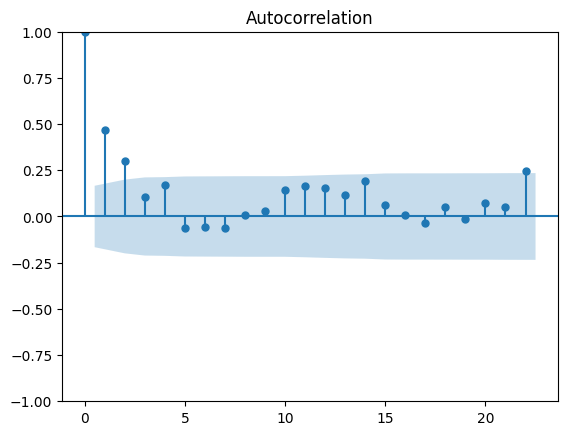

In [137]:
plot_acf(denver_incidents_per_month['percentage_pedestrian_incidents'])
plt.show()

ACF Plot shows autocorrelation at 1 and 2 lags so we will use ARIMA instead of OLS

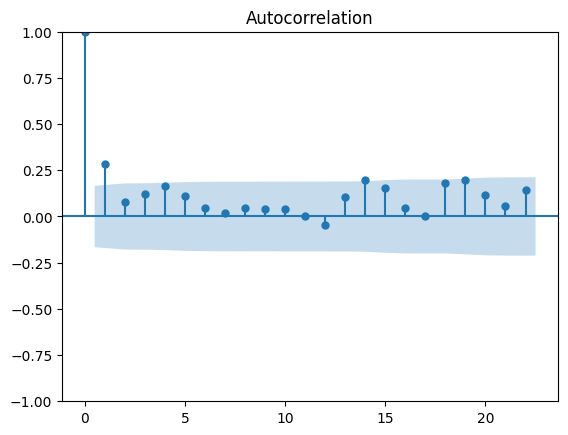

In [138]:
plot_acf(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'])
plt.show()

ACF Plot shows autocorrelation at 1 lag so we will use ARIMA instead of OLS

In [47]:
# Test with no seasonality and P variable
auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=5, max_q=5, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-834.983, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1051.297, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-920.725, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1061.608, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1060.092, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1060.764, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1063.817, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1060.778, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-974.856, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1053.346, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1075.480, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-958.718, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1067.974, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1071.589, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 549.688
Date:                Thu, 01 Aug 2024   AIC                          -1085.375
Time:                        12:36:10   BIC                          -1064.834
Sample:                             0   HQIC                         -1077.028
                                - 139                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0241      0.002     15.361      0.000       0.021       0.027
T           -1.54e-05   2.12e-05     -0.725      0.468    -5.7e-05    2.62e-05
D             -0.0040      0.004     -1.088      0.277      -0.011       0.003
P              0.0008      0.000      2.293      0.022       0.000       0.002
ma.L1          0.5812      0.072      8.034      0.000       0.439       0.723
ma.L2          0.4795      0.069      6.946      0.000       0.344       0.615
sigma2      2.142e-05   3.08e-06      6.962      0.000    1.54e-05    2.75e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.29   Prob(JB):                         0.37
Heteroskedasticity (H):               1.48   Skew:                             0.23
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
# Test with seasonality and P variable
auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=5, max_q=5, # Maximum p and q
                      m=12,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=True,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1057.004, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-883.906, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1029.850, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-969.611, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-834.983, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-897.206, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1027.407, Time=0.93 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-1045.993, Time=0.84 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-1073.170, Time=2.03 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-1059.894, Time=1.08 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-1072.522, Time=1.63 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-1046.406, Time=1.95 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-1058.901, Time=2.95 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-1058.064, Time=1.20 sec
 ARIMA(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                  139
Model:             SARIMAX(1, 0, [1, 2], 12)   Log Likelihood                 544.585
Date:                       Thu, 22 Aug 2024   AIC                          -1073.170
Time:                               13:21:55   BIC                          -1049.694
Sample:                                    0   HQIC                         -1063.630
                                       - 139                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0171      0.005      3.352      0.001       0.007       0.027
T          -5.189e-06   1.52e-05     -0.341      0.733    -3.5e-05    2.46e-05
D              0.0026      0.002      1.192      0.233      -0.002       0.007
P              0.0003      0.000      1.136      0.256      -0.000       0.001
ar.S.L12       0.2747      0.213      1.289      0.198      -0.143       0.692
ma.S.L12      -0.3222      0.190     -1.693      0.091      -0.695       0.051
ma.S.L24       0.5036      0.104      4.843      0.000       0.300       0.707
sigma2      2.244e-05   3.08e-06      7.295      0.000    1.64e-05    2.85e-05
===================================================================================
Ljung-Box (L1) (Q):                  11.71   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.00   Prob(JB):                         0.40
Heteroskedasticity (H):               2.10   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
# Test with no seasonality and P_prime variable
auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'], 
                      X=denver_incidents_per_month[['T','D','P_prime']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=5, max_q=5, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-834.994, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1051.289, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-920.642, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1061.596, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1060.074, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1060.992, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1064.183, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1060.743, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-974.895, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1053.374, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1075.464, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1060.689, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1067.693, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1072.021, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 550.427
Date:                Mon, 26 Aug 2024   AIC                          -1086.854
Time:                        10:30:48   BIC                          -1066.312
Sample:                             0   HQIC                         -1078.506
                                - 139                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0250      0.002     15.916      0.000       0.022       0.028
T          -3.006e-05   2.13e-05     -1.409      0.159   -7.19e-05    1.17e-05
D              0.0033      0.005      0.640      0.522      -0.007       0.013
P_prime        0.0003      0.000      0.566      0.571      -0.001       0.001
ma.L1          0.5814      0.069      8.374      0.000       0.445       0.718
ma.L2          0.4793      0.068      7.064      0.000       0.346       0.612
sigma2      2.105e-05   3.12e-06      6.741      0.000    1.49e-05    2.72e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):                 2.52
Prob(Q):                              0.17   Prob(JB):                         0.28
Heteroskedasticity (H):               1.44   Skew:                             0.25
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
# Test with seasonality and P_prime variable
auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'], 
                      X=denver_incidents_per_month[['T','D','P_prime']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=12, max_q=12, # Maximum p and q
                      m=12,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=True,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1057.004, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-883.906, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1029.850, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-969.611, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-834.983, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-897.206, Time=0.36 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1027.407, Time=1.10 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-1045.993, Time=1.06 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-1073.170, Time=2.47 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-1059.894, Time=1.04 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-1072.522, Time=1.89 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-1046.406, Time=1.84 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-1058.901, Time=3.09 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-1058.064, Time=1.41 sec
 ARIMA(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                  139
Model:             SARIMAX(1, 0, [1, 2], 12)   Log Likelihood                 544.585
Date:                       Thu, 15 Aug 2024   AIC                          -1073.170
Time:                               11:06:44   BIC                          -1049.694
Sample:                                    0   HQIC                         -1063.630
                                       - 139                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0171      0.005      3.352      0.001       0.007       0.027
T          -5.189e-06   1.52e-05     -0.341      0.733    -3.5e-05    2.46e-05
D              0.0026      0.002      1.192      0.233      -0.002       0.007
P              0.0003      0.000      1.136      0.256      -0.000       0.001
ar.S.L12       0.2747      0.213      1.289      0.198      -0.143       0.692
ma.S.L12      -0.3222      0.190     -1.693      0.091      -0.695       0.051
ma.S.L24       0.5036      0.104      4.843      0.000       0.300       0.707
sigma2      2.244e-05   3.08e-06      7.295      0.000    1.64e-05    2.85e-05
===================================================================================
Ljung-Box (L1) (Q):                  11.71   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.00   Prob(JB):                         0.40
Heteroskedasticity (H):               2.10   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

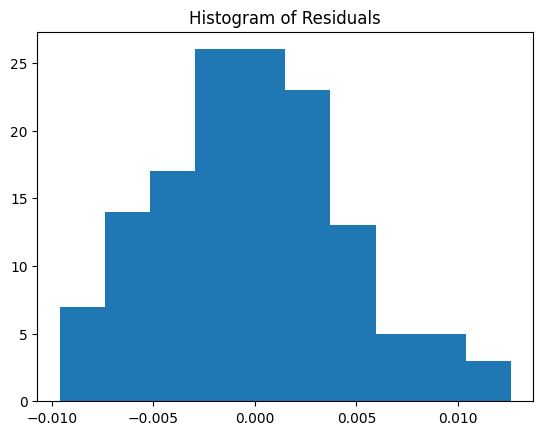

In [37]:
# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-563.165, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-912.761, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-670.936, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-925.732, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-924.301, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-925.141, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-928.832, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-927.067, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-769.811, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-930.625, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-918.546, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-939.230, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-933.787, Time=0.02 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-935.946, Time=0.03 sec
 ARIMA(2,0,4)(0,0,0)[0]          

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_38395/1734326494.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


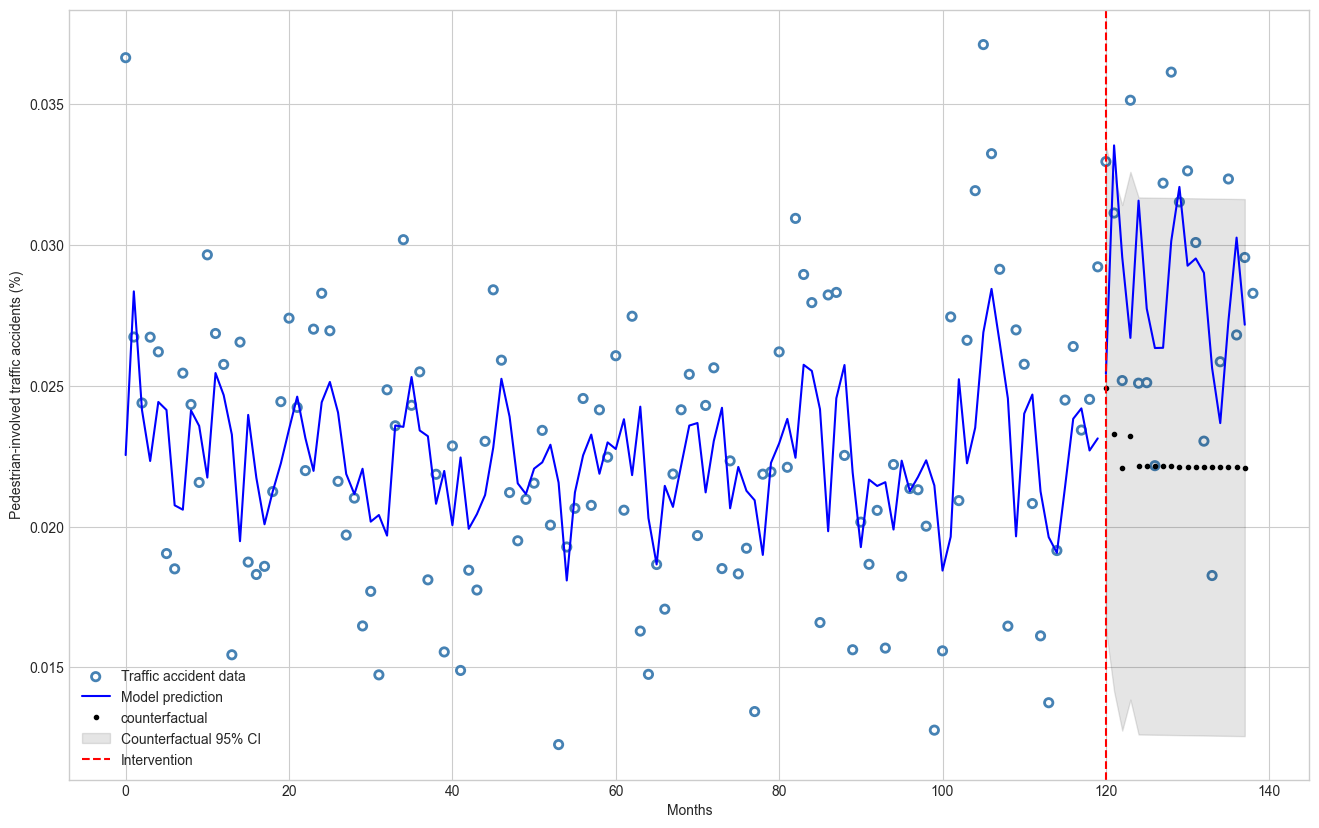

In [85]:
# Plot before and after intervention predicitons 
# auto_model_full is the model with no seasonality and P variable

start = 120
end = len(denver_incidents_per_month)

arima_results = ARIMA(denver_incidents_per_month['percentage_pedestrian_incidents'], denver_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'][:start], exogenous=denver_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=5, max_q=5, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(denver_incidents_per_month['percentage_pedestrian_incidents'][:start], denver_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=denver_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(denver_incidents_per_month["T"], denver_incidents_per_month["percentage_pedestrian_incidents"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(denver_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(denver_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=denver_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Pedestrian-involved traffic accidents (%)")
plt.show()

### Non-Intersection Pedestrian-Vehicle Crashes

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1045.394, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1182.445, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1107.295, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1191.423, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1201.102, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-1205.830, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-1203.568, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1202.522, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1196.161, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1201.219, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1215.322, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1211.563, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-1216.065, Time=0.28 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=-1214.355, Time=0.25 sec
 ARIMA(5,0,1)(0,0,0

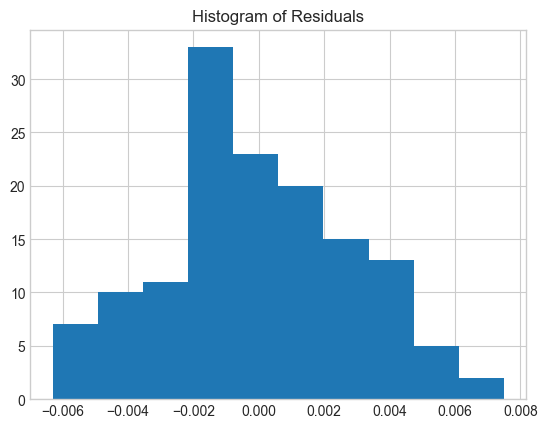

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-749.317, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1010.843, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-850.814, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1026.248, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1041.170, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1036.580, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1047.681, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1049.515, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=-1048.192, Time=0.03 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-1048.925, Time=0.04 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-1052.677, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : A

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_28297/940656549.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


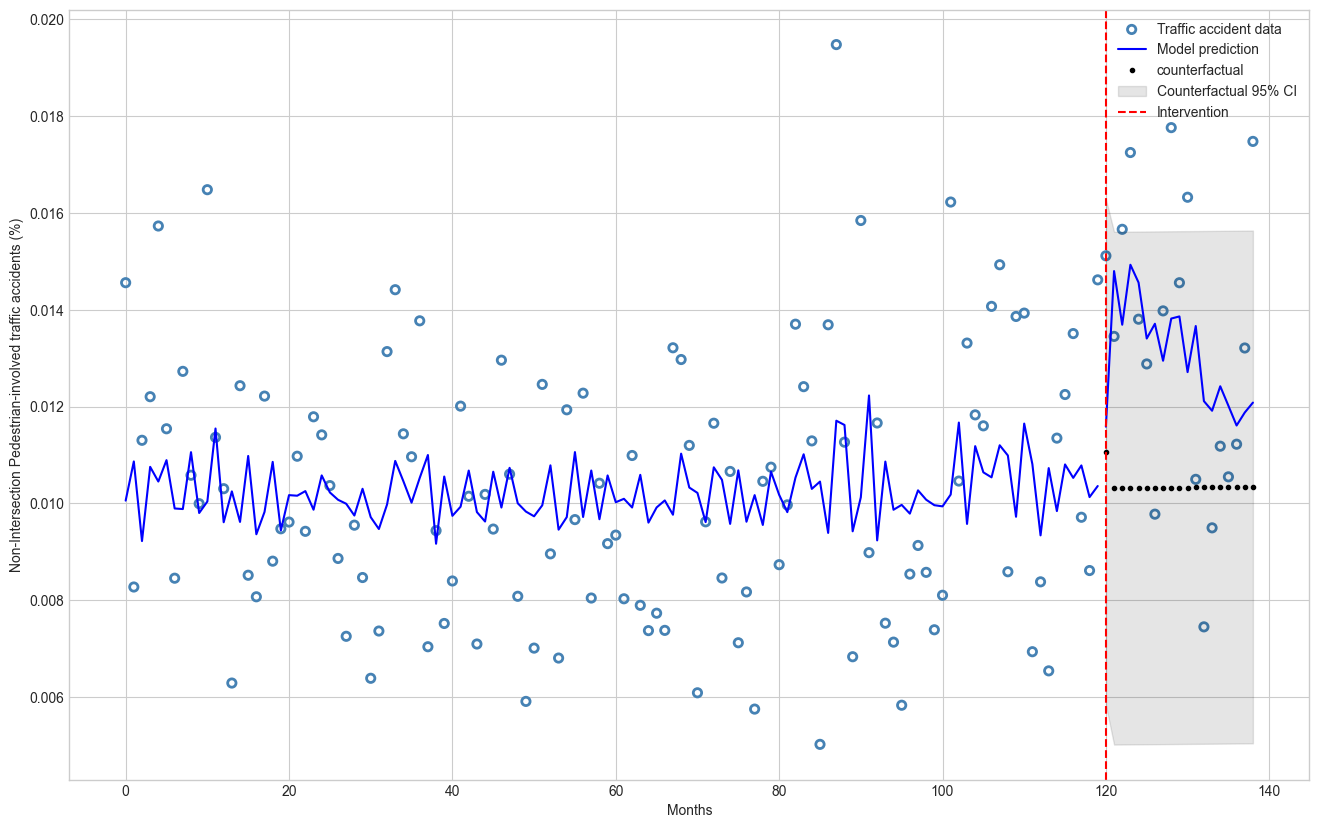

In [229]:
# Plot before and after intervention predicitons 
# auto_model_full is the model with no seasonality and P variable

auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

print(auto_model_full.summary())

# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()
start = 120
end = len(denver_incidents_per_month)

arima_results = ARIMA(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'], denver_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'][:start], exogenous=denver_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=20, max_q=20, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'][:start], denver_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=denver_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(denver_incidents_per_month["T"], denver_incidents_per_month["percentage_pedestrian_nonintersection_incidents"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(denver_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(denver_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=denver_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Non-Intersection Pedestrian-involved traffic accidents (%)")
plt.show()

In [141]:
# Model with no seasonality and P variable

auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1045.394, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1182.445, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1107.295, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1191.423, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1201.102, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-1205.830, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-1203.568, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1202.522, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1196.161, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1201.219, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1215.322, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1211.563, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-1216.065, Time=0.16 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=-1214.355, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(5, 0, 0)   Log Likelihood                 618.032
Date:                Thu, 15 Aug 2024   AIC                          -1216.065
Time:                        10:35:44   BIC                          -1186.720
Sample:                             0   HQIC                         -1204.140
                                - 139                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.002      0.895      0.371      -0.002       0.005
T          -4.024e-06   3.44e-05     -0.117      0.907   -7.15e-05    6.34e-05
D             -0.0007      0.003     -0.250      0.802      -0.006       0.005
P              0.0002      0.000      1.002      0.316      -0.000       0.001
ar.L1          0.3703      0.093      3.981      0.000       0.188       0.553
ar.L2          0.0297      0.090      0.329      0.742      -0.147       0.207
ar.L3          0.1685      0.086      1.950      0.051      -0.001       0.338
ar.L4          0.1544      0.090      1.723      0.085      -0.021       0.330
ar.L5          0.1301      0.095      1.371      0.170      -0.056       0.316
sigma2      7.836e-06    1.2e-06      6.517      0.000    5.48e-06    1.02e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.72   Prob(JB):                         0.70
Heteroskedasticity (H):               1.45   Skew:                             0.10
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
# Model with no seasonality and P_prime variable

auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1045.394, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1182.445, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1107.295, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1191.423, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1201.102, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-1205.830, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-1203.568, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1202.522, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1196.161, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1201.219, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1215.322, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1211.563, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-1216.065, Time=0.18 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=-1214.355, Time=0.25 sec
 ARIMA(5,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(5, 0, 0)   Log Likelihood                 618.032
Date:                Thu, 22 Aug 2024   AIC                          -1216.065
Time:                        13:14:41   BIC                          -1186.720
Sample:                             0   HQIC                         -1204.140
                                - 139                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.002      0.895      0.371      -0.002       0.005
T          -4.024e-06   3.44e-05     -0.117      0.907   -7.15e-05    6.34e-05
D             -0.0007      0.003     -0.250      0.802      -0.006       0.005
P              0.0002      0.000      1.002      0.316      -0.000       0.001
ar.L1          0.3703      0.093      3.981      0.000       0.188       0.553
ar.L2          0.0297      0.090      0.329      0.742      -0.147       0.207
ar.L3          0.1685      0.086      1.950      0.051      -0.001       0.338
ar.L4          0.1544      0.090      1.723      0.085      -0.021       0.330
ar.L5          0.1301      0.095      1.371      0.170      -0.056       0.316
sigma2      7.836e-06    1.2e-06      6.517      0.000    5.48e-06    1.02e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.72   Prob(JB):                         0.70
Heteroskedasticity (H):               1.45   Skew:                             0.10
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Virginia Beach

## Read in data

In [2]:
# https://drive.google.com/file/d/1DBFAzfgXdHNaCiXlfn859P3PSde_LokI/view?usp=drive_link
virginia_df = pd.read_csv("../data/input/CrashData_test_6478750435646127290.csv")
virginia_df

,OBJECTID,Document Nbr,Crash Year,Crash Date,Crash Military Time,Crash Severity,K_People,A_People,B_People,C_People,...,VSP,Ownership,Planning District,MPO Name,RTE Name,RNS MP,Node,Node Offset (ft),x,y
0,1,163465085,2016,12/6/2016 5:00:00 AM,700,O,0,0,0,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA IS00095NB,158.85,NaN,NaN,-77.280787,38.653845
1,2,160725125,2016,1/26/2016 5:00:00 AM,1636,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA114NP WOODLAND RD,0.50,253154.0,318.32,-76.322790,37.027737
2,3,160465260,2016,2/13/2016 5:00:00 AM,1845,B,0,0,2,0,...,1,1. State Hwy Agency,Northern Neck,NaN,R-VA066SC00640NB,2.54,1149141.0,5.82,-76.362036,37.898547
3,4,161255113,2016,3/26/2016 4:00:00 AM,1,O,0,0,0,0,...,1,1. State Hwy Agency,Richmond Regional,RICH,R-VA042SC00782SB,1.19,NaN,NaN,-77.453780,37.695529
4,5,162005180,2016,7/18/2016 4:00:00 AM,732,O,0,0,0,0,...,6,1. State Hwy Agency,"Roanoke Valley-Alleghany, West Piedmont",NaN,R-VA US00220NB,48.61,328737.0,5.34,-79.942464,37.103654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040819,1040820,240455170,2024,2/10/2024 5:00:00 AM,1153,B,0,0,2,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,R-VA SR00168NBBUS001,11.51,1094526.0,68.79,-76.240189,36.733799
1040820,1040821,240465044,2024,2/10/2024 5:00:00 AM,1755,O,0,0,0,0,...,5,1. State Hwy Agency,Hampton Roads,HAMP,R-VA IS00064WB RMP278.00A,0.14,NaN,NaN,-76.238467,36.904584
1040821,1040822,240835174,2024,3/22/2024 4:00:00 AM,1434,B,0,0,3,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA IS00395NB,6.25,NaN,NaN,-77.094333,38.835522
1040822,1040823,240925234,2024,3/31/2024 4:00:00 AM,1952,O,0,0,0,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA IS00495SB,6.71,NaN,NaN,-77.220283,38.850899


In [3]:
# Filter to only Virginia Beach
vb_df = virginia_df[virginia_df['Physical Juris Name'].str.contains('Virginia Beach', flags=re.IGNORECASE)]

In [4]:
vb_df

,OBJECTID,Document Nbr,Crash Year,Crash Date,Crash Military Time,Crash Severity,K_People,A_People,B_People,C_People,...,VSP,Ownership,Planning District,MPO Name,RTE Name,RNS MP,Node,Node Offset (ft),x,y
14,15,160575250,2016,2/25/2016 5:00:00 AM,1827,B,0,0,1,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134NP GENERAL BOOTH BLVD,4.20,1041506.0,191.85,-76.006695,36.774809
20,21,160105153,2016,1/8/2016 5:00:00 AM,1743,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,R-VA US00058WB,500.94,1262135.0,185.10,-76.129230,36.843566
75,76,162305330,2016,8/17/2016 4:00:00 AM,1635,B,0,0,1,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,R-VA US00058EB,504.77,1091398.0,27.19,-76.063078,36.841365
76,77,170340061,2016,11/25/2016 5:00:00 AM,1820,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134NP WESLEYAN DR,2.01,1261844.0,22.11,-76.186426,36.872855
124,125,161645081,2016,6/10/2016 4:00:00 AM,942,B,0,0,1,1,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134PR BIRDNECK RD S,2.66,542025.0,97.65,-75.995777,36.844128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040766,1040767,241645584,2024,5/31/2024 4:00:00 AM,207,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134NP FERRELL PKWY,0.48,NaN,NaN,-76.131520,36.796350
1040804,1040805,240345094,2024,1/27/2024 5:00:00 AM,628,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134NP WESLEYAN DR,1.69,1087290.0,62.94,-76.181144,36.871365
1040807,1040808,241105255,2024,4/13/2024 4:00:00 AM,1743,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134NP LYNNHAVEN PKWY,4.81,1091355.0,114.59,-76.108215,36.794608
1040810,1040811,241535011,2024,5/28/2024 4:00:00 AM,2148,B,0,0,1,1,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA134NP GENERAL BOOTH BLVD,3.35,541475.0,66.95,-75.999134,36.786029


## Data Cleaning

In [5]:
# Convert to datetime
vb_df['Crash Datetime'] = pd.to_datetime(vb_df['Crash Date'])

/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_28297/870009613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vb_df['Crash Datetime'] = pd.to_datetime(vb_df['Crash Date'])


In [6]:
# Create month column
vb_df['crash_month'] = vb_df['Crash Datetime'].dt.month

/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_28297/2493939417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vb_df['crash_month'] = vb_df['Crash Datetime'].dt.month


In [7]:
# Create table with total crashes per month and year
vb_total_crashes_month_year = vb_df.groupby(['crash_month', 'Crash Year']).count()['OBJECTID']
vb_total_crashes_month_year = vb_total_crashes_month_year.reset_index().rename(columns={'OBJECTID':'total_crashes'})

In [8]:
# Create table with total pedestrian crashes per month and year
vb_total_pedesrian_crashes_month_year = vb_df[vb_df['Pedestrian?']=='Yes'].groupby(['crash_month', 'Crash Year']).count()['OBJECTID']
vb_total_pedesrian_crashes_month_year = vb_total_pedesrian_crashes_month_year.reset_index().rename(columns={'OBJECTID':'total_pedestrian_crashes'})

In [9]:
# Create table with total pedestrian crashes at non-intersections per month and year
vb_total_pedestrian_nonintersection_crashes_month_year = vb_df[(vb_df['Pedestrian?']=='Yes') & (vb_df['Intersection Type']=='1. Not at Intersection')].groupby(['crash_month', 'Crash Year']).count()['OBJECTID']
vb_total_pedestrian_nonintersection_crashes_month_year = vb_total_pedestrian_nonintersection_crashes_month_year.reset_index().rename(columns={'OBJECTID':'total_pedestrian_nonintersection_crashes'})

In [10]:
# Merge tables together
vb_incidents_per_month = pd.merge(vb_total_crashes_month_year, vb_total_pedesrian_crashes_month_year, how='outer', left_on=['crash_month','Crash Year'], right_on=['crash_month','Crash Year'])
vb_incidents_per_month = pd.merge(vb_incidents_per_month, vb_total_pedestrian_nonintersection_crashes_month_year, how='outer', left_on=['crash_month','Crash Year'], right_on=['crash_month','Crash Year'])
vb_incidents_per_month

,crash_month,Crash Year,total_crashes,total_pedestrian_crashes,total_pedestrian_nonintersection_crashes
0,1,2016,517,7.0,2.0
1,1,2017,493,7.0,3.0
2,1,2018,523,4.0,NaN
3,1,2019,452,1.0,1.0
4,1,2020,517,4.0,2.0
...,...,...,...,...,...
96,12,2019,555,7.0,3.0
97,12,2020,433,6.0,5.0
98,12,2021,491,4.0,1.0
99,12,2022,464,3.0,1.0


In [11]:
# Calculate percentage of pedestrian crashes
vb_incidents_per_month['percentage_pedestrian_crashes'] = vb_incidents_per_month['total_pedestrian_crashes'] / vb_incidents_per_month['total_crashes']

In [12]:
# Calculate percentage of pedestrian crashes at non-intersections
vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'] = vb_incidents_per_month['total_pedestrian_nonintersection_crashes'] / vb_incidents_per_month['total_crashes']

In [13]:
# Sort by year and month
vb_incidents_per_month = vb_incidents_per_month.sort_values(by=['Crash Year','crash_month'])

In [14]:
# Create T, D, and P features
vb_incidents_per_month = vb_incidents_per_month.reset_index().drop(columns='index').reset_index().rename(columns={'index':'T'})
vb_incidents_per_month['D'] = vb_incidents_per_month.apply(lambda row: 1 if (row['crash_month'] > 2 and row['Crash Year'] == 2021) or (row['Crash Year'] > 2021) else 0, axis=1)
vb_incidents_per_month['P'] = vb_incidents_per_month['D'].cumsum()

In [15]:
vb_incidents_per_month

,T,crash_month,Crash Year,total_crashes,total_pedestrian_crashes,total_pedestrian_nonintersection_crashes,percentage_pedestrian_crashes,percentage_pedestrian_nonintersection_crashes,D,P
0,0,1,2016,517,7.0,2.0,0.013540,0.003868,0,0
1,1,2,2016,569,10.0,4.0,0.017575,0.007030,0,0
2,2,3,2016,571,7.0,2.0,0.012259,0.003503,0,0
3,3,4,2016,704,9.0,2.0,0.012784,0.002841,0,0
4,4,5,2016,627,8.0,3.0,0.012759,0.004785,0,0
...,...,...,...,...,...,...,...,...,...,...
96,96,1,2024,362,7.0,3.0,0.019337,0.008287,1,35
97,97,2,2024,419,5.0,1.0,0.011933,0.002387,1,36
98,98,3,2024,439,9.0,6.0,0.020501,0.013667,1,37
99,99,4,2024,424,6.0,NaN,0.014151,NaN,1,38


In [92]:
# Create feature for time since intervention - 1 (P_prime) to test for multicollinearity in the model
vb_incidents_per_month['P_prime'] = vb_incidents_per_month.apply(lambda x: x['P'] - 1 if x['D'] != 0 else 0, axis=1)

In [16]:
# Fill missing values
vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'].fillna(0, inplace=True)
vb_incidents_per_month['percentage_pedestrian_crashes'].fillna(0, inplace=True)

## Modeling

In [71]:
original = vb_incidents_per_month.copy()

In [83]:
vb_incidents_per_month = original.copy()

### Non-Intersection Pedestrian-Vehicle Crashes

ADF Statistic: -11.347436
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582
Series is stationary
None


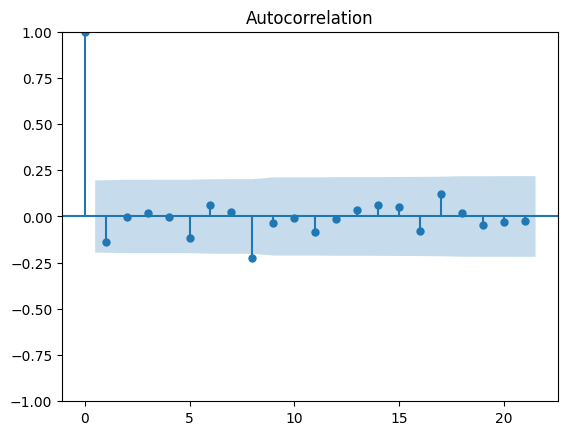

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-812.643, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-811.529, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-811.090, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-808.926, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-816.259, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-814.142, Time=0.04 sec


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-813.424, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-810.511, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.381 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  101
Model:                        SARIMAX   Log Likelihood                 413.130
Date:                Wed, 28 Aug 2024   AIC                           -816.259
Time:                        03:34:17   BIC                           -803.183
Sample:                             0   HQIC                          -810.966
                                - 101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
i

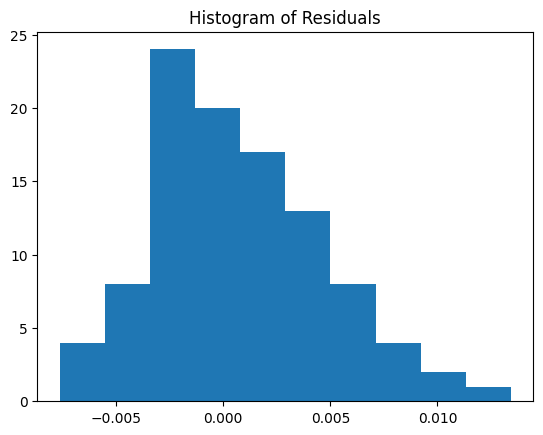

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-452.013, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-487.684, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-470.525, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-496.949, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-506.625, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-506.974, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-507.578, Time=0.01 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-508.058, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-505.151, Time=0.03 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=-509.267, Time=0.08 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=-506.751, Time=0.10 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=-505.815, Time=0.06 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-501.520, Time=0.09 sec
 ARIMA(7,0,0)(0,0,0)[0]             : 

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_28297/4260432673.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


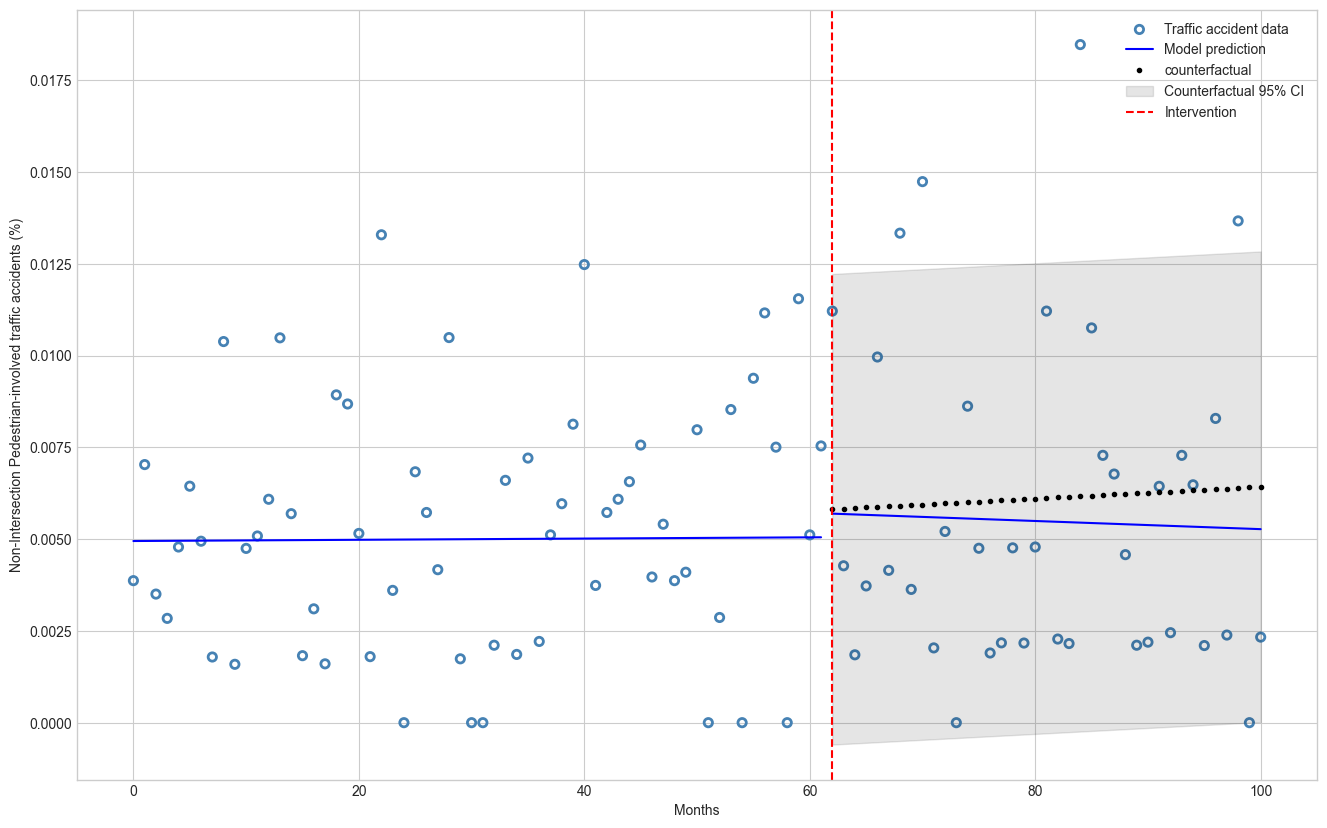

In [161]:
# Run ARIMA ITSA on the data
print(test_stationarity(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes']))

plot_acf(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'])
plt.show()

auto_model_full = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'], 
                      X=vb_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

print(auto_model_full.summary())

# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()
start = 62
end = len(vb_incidents_per_month)

arima_results = ARIMA(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'], vb_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'][:start], exogenous=vb_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=20, max_q=20, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'][:start], vb_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=vb_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(vb_incidents_per_month["T"], vb_incidents_per_month["percentage_pedestrian_nonintersection_crashes"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(vb_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(vb_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=vb_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Non-Intersection Pedestrian-involved traffic accidents (%)")
plt.show()

The ACF plot shows no autocorrelation so we can use OLS instead of ARIMA

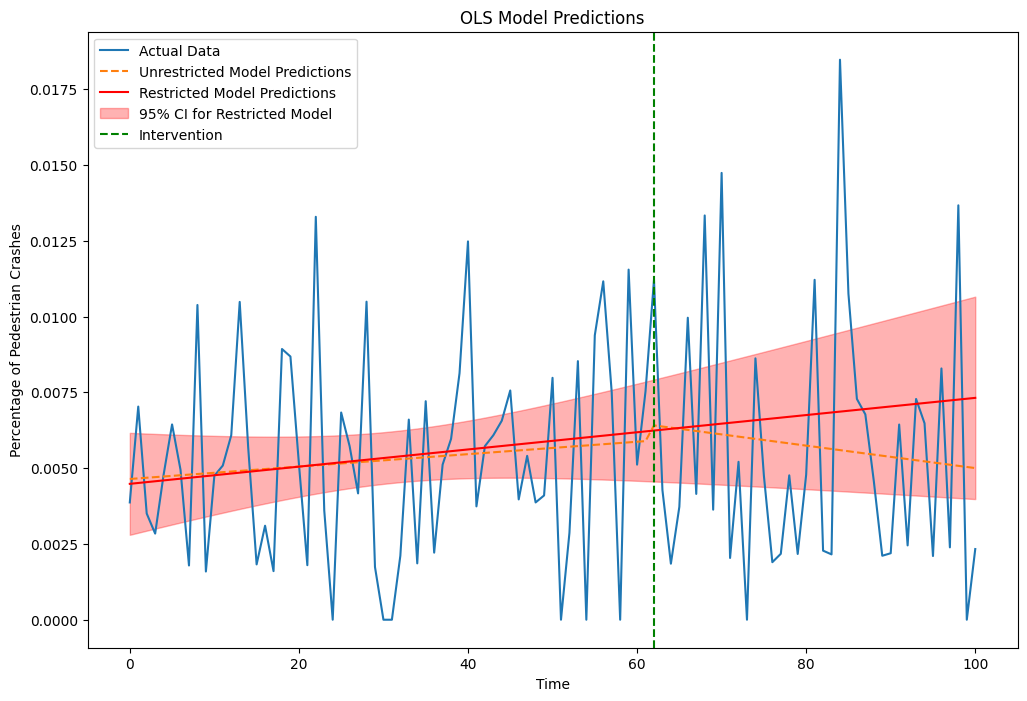

In [101]:
# ITS Analysis with OLS and P variable

# Define the intervention point
start = 62

# Fit unrestricted OLS model
X_full = sm.add_constant(vb_incidents_per_month[['T', 'D', 'P']])
y_full = vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes']
model_full = sm.OLS(y_full, X_full).fit()

# Fit restricted OLS model (using data up to 'start' and only 'T')
X_restricted = sm.add_constant(vb_incidents_per_month.loc[:start, ['T']])
y_restricted = vb_incidents_per_month.loc[:start, 'percentage_pedestrian_nonintersection_crashes']
model_restricted = sm.OLS(y_restricted, X_restricted).fit()

# Making predictions from both models
vb_incidents_per_month['predictions_full'] = model_full.predict(X_full)

# Properly structure X for predictions from the restricted model over the full dataset
X_restricted_full = sm.add_constant(vb_incidents_per_month[['T']])  # including constant term
predictions_restricted = model_restricted.get_prediction(X_restricted_full)
summary_frame = predictions_restricted.summary_frame(alpha=0.05)

# Plotting the data and models
plt.figure(figsize=(12, 8))
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'], label='Actual Data')
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['predictions_full'], label='Unrestricted Model Predictions', linestyle='--')
plt.plot(vb_incidents_per_month['T'], summary_frame['mean'], label='Restricted Model Predictions', color='red')
plt.fill_between(vb_incidents_per_month['T'], summary_frame['mean_ci_lower'], summary_frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI for Restricted Model')
plt.axvline(x=vb_incidents_per_month['T'][start], color='green', linestyle='--', label='Intervention')
plt.xlabel('Time')
plt.ylabel('Percentage of Pedestrian Crashes')
plt.title('OLS Model Predictions')
plt.legend()
plt.show()

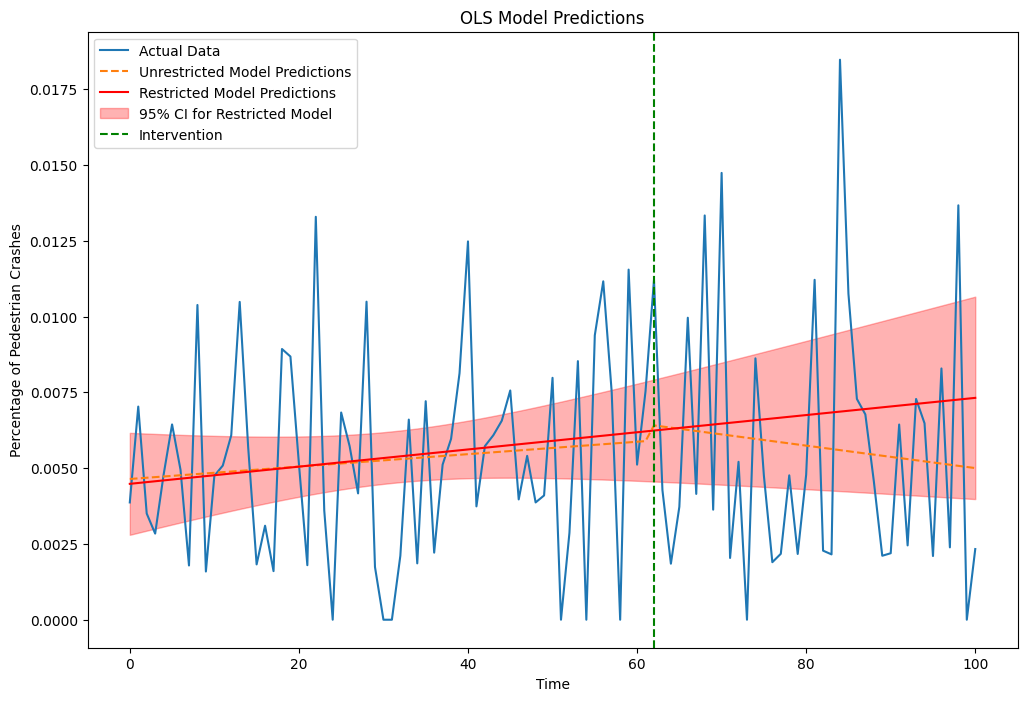

In [103]:
# ITS Analysis with OLS and P_prime variable
# Define the intervention point
start = 62

# Fit unrestricted OLS model
X_full = sm.add_constant(vb_incidents_per_month[['T', 'D', 'P_prime']])
y_full = vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes']
model_full = sm.OLS(y_full, X_full).fit()

# Fit restricted OLS model (using data up to 'start' and only 'T')
X_restricted = sm.add_constant(vb_incidents_per_month.loc[:start, ['T']])
y_restricted = vb_incidents_per_month.loc[:start, 'percentage_pedestrian_nonintersection_crashes']
model_restricted = sm.OLS(y_restricted, X_restricted).fit()

# Making predictions from both models
vb_incidents_per_month['predictions_full'] = model_full.predict(X_full)

# Properly structure X for predictions from the restricted model over the full dataset
X_restricted_full = sm.add_constant(vb_incidents_per_month[['T']])  # including constant term
predictions_restricted = model_restricted.get_prediction(X_restricted_full)
summary_frame = predictions_restricted.summary_frame(alpha=0.05)

# Plotting the data and models
plt.figure(figsize=(12, 8))
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'], label='Actual Data')
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['predictions_full'], label='Unrestricted Model Predictions', linestyle='--')
plt.plot(vb_incidents_per_month['T'], summary_frame['mean'], label='Restricted Model Predictions', color='red')
plt.fill_between(vb_incidents_per_month['T'], summary_frame['mean_ci_lower'], summary_frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI for Restricted Model')
plt.axvline(x=vb_incidents_per_month['T'][start], color='green', linestyle='--', label='Intervention')
plt.xlabel('Time')
plt.ylabel('Percentage of Pedestrian Crashes')
plt.title('OLS Model Predictions')
plt.legend()
plt.show()

In [104]:
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                         
=========================================================================================================
Dep. Variable:     percentage_pedestrian_nonintersection_crashes   R-squared:                       0.014
Model:                                                       OLS   Adj. R-squared:                 -0.017
Method:                                            Least Squares   F-statistic:                    0.4548
Date:                                           Thu, 15 Aug 2024   Prob (F-statistic):              0.715
Time:                                                   10:10:51   Log-Likelihood:                 421.58
No. Observations:                                            101   AIC:                            -835.2
Df Residuals:                                                 97   BIC:                            -824.7
Df Model:                                                      3                                         
Covariance Type:                                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      4.868      0.000       0.003       0.007
T           2.047e-05    2.7e-05      0.759      0.450   -3.31e-05     7.4e-05
D              0.0005      0.002      0.322      0.748      -0.003       0.004
P_prime     -5.75e-05   6.04e-05     -0.952      0.344      -0.000    6.24e-05
==============================================================================
Omnibus:                       10.443   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.573
Skew:                           0.762   Prob(JB):                      0.00506
Kurtosis:                       3.438   Cond. No.                         247.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
model_restricted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                         
=========================================================================================================
Dep. Variable:     percentage_pedestrian_nonintersection_crashes   R-squared:                       0.024
Model:                                                       OLS   Adj. R-squared:                  0.008
Method:                                            Least Squares   F-statistic:                     1.469
Date:                                           Wed, 14 Aug 2024   Prob (F-statistic):              0.230
Time:                                                   14:02:07   Log-Likelihood:                 270.15
No. Observations:                                             63   AIC:                            -536.3
Df Residuals:                                                 61   BIC:                            -532.0
Df Model:                                                      1                                         
Covariance Type:                                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.001      5.330      0.000       0.003       0.006
T           2.835e-05   2.34e-05      1.212      0.230   -1.84e-05    7.51e-05
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.996
Skew:                           0.229   Prob(JB):                        0.608
Kurtosis:                       2.588   Cond. No.                         71.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
X_full = sm.add_constant(vb_incidents_per_month[['D']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.019
Model:                                       OLS   Adj. R-squared:                  0.009
Method:                            Least Squares   F-statistic:                     1.887
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):              0.173
Time:                                   14:02:08   Log-Likelihood:                 384.51
No. Observations:                            101   AIC:                            -765.0
Df Residuals:                                 99   BIC:                            -759.8
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.001     18.452      0.000       0.011       0.014
D              0.0015      0.001      1.374      0.173      -0.001       0.004
==============================================================================
Omnibus:                        0.056   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.068
Skew:                           0.047   Prob(JB):                        0.966
Kurtosis:                       2.913   Cond. No.                         2.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
X_full = sm.add_constant(vb_incidents_per_month[['T','D']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.019
Model:                                       OLS   Adj. R-squared:                 -0.001
Method:                            Least Squares   F-statistic:                    0.9375
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):              0.395
Time:                                   14:22:38   Log-Likelihood:                 384.51
No. Observations:                            101   AIC:                            -763.0
Df Residuals:                                 98   BIC:                            -755.2
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126      0.001      9.999      0.000       0.010       0.015
T           2.801e-06   3.47e-05      0.081      0.936    -6.6e-05    7.16e-05
D              0.0014      0.002      0.666      0.507      -0.003       0.006
==============================================================================
Omnibus:                        0.051   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.057
Skew:                           0.042   Prob(JB):                        0.972
Kurtosis:                       2.919   Cond. No.                         235.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
X_full = sm.add_constant(vb_incidents_per_month[['T','P']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.031
Model:                                       OLS   Adj. R-squared:                  0.011
Method:                            Least Squares   F-statistic:                     1.571
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):              0.213
Time:                                   14:02:08   Log-Likelihood:                 385.15
No. Observations:                            101   AIC:                            -764.3
Df Residuals:                                 98   BIC:                            -756.4
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.001     10.124      0.000       0.011       0.016
T          -1.285e-05   3.27e-05     -0.393      0.696   -7.78e-05    5.21e-05
P              0.0001   7.96e-05      1.301      0.196   -5.44e-05       0.000
==============================================================================
Omnibus:                        0.249   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.883   Jarque-Bera (JB):                0.170
Skew:                           0.099   Prob(JB):                        0.918
Kurtosis:                       2.968   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
X_full = sm.add_constant(vb_incidents_per_month[['P']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.030
Model:                                       OLS   Adj. R-squared:                  0.020
Method:                            Least Squares   F-statistic:                     3.013
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):             0.0857
Time:                                   14:02:09   Log-Likelihood:                 385.07
No. Observations:                            101   AIC:                            -766.1
Df Residuals:                                 99   BIC:                            -760.9
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.001     19.890      0.000       0.011       0.014
P           7.778e-05   4.48e-05      1.736      0.086   -1.11e-05       0.000
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.075
Skew:                           0.064   Prob(JB):                        0.963
Kurtosis:                       2.964   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### All Pedestrian-Vehicle Crashes

ADF Statistic: -10.985010
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582
Series is stationary
None


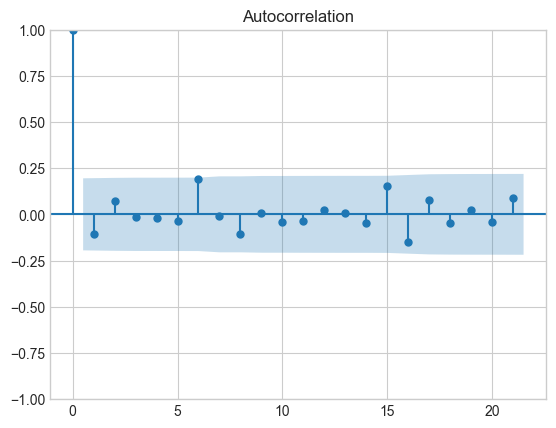

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-693.915, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-709.822, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-698.626, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-724.514, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-727.527, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-727.258, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-725.749, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-733.300, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-736.541, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-730.254, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-706.218, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=144.717, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-744.851, Time=0.04 sec


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-706.632, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-734.156, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-740.816, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-743.396, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-750.376, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.926 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  101
Model:                        SARIMAX   Log Likelihood                 380.188
Date:                Wed, 28 Aug 2024   AIC                           -750.376
Time:                        04:37:14   BIC                           -737.300
Sample:                             0   HQIC                          -745.083
                                - 101                                         
Covariance Type:                  opg   

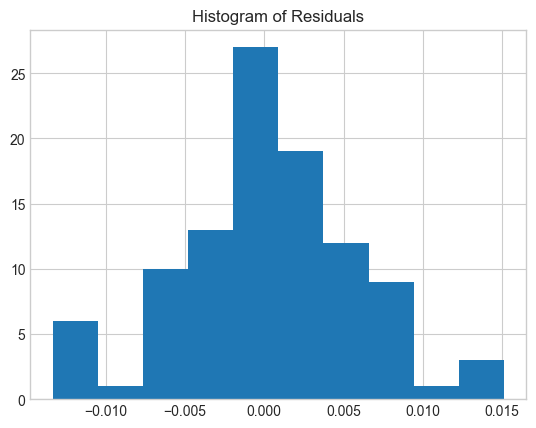

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-354.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-433.954, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-388.577, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-446.646, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-451.035, Time=0.02 sec


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-450.091, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-448.996, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-453.994, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-467.057, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-444.597, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-401.845, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-472.151, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-474.134, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-476.118, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-474.156, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.456 seconds


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_28297/2366668695.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


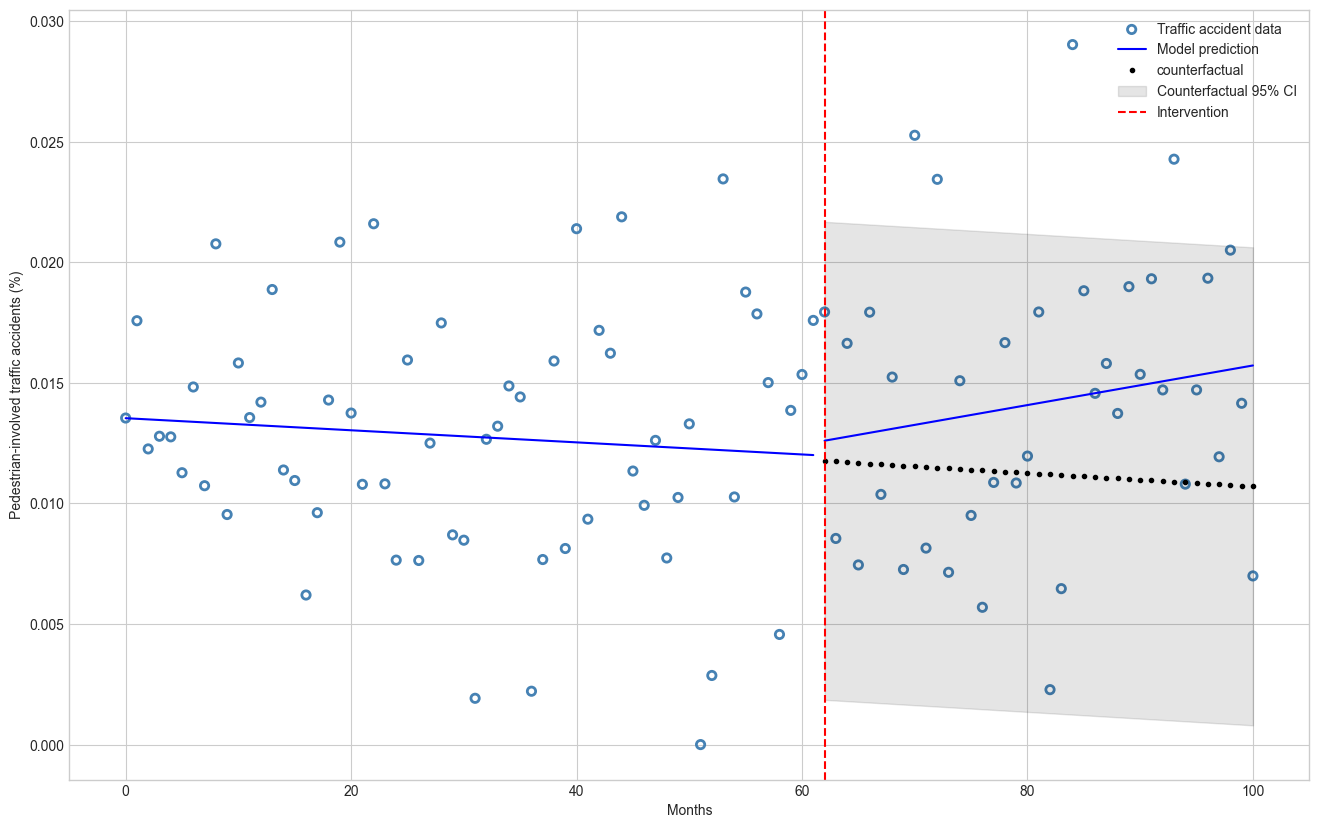

In [205]:
# Run ARIMA ITSA on the data

print(test_stationarity(vb_incidents_per_month['percentage_pedestrian_crashes']))

plot_acf(vb_incidents_per_month['percentage_pedestrian_crashes'])
plt.show()

auto_model_full = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_crashes'], 
                      X=vb_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

print(auto_model_full.summary())

# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()
start = 62
end = len(vb_incidents_per_month)

arima_results = ARIMA(vb_incidents_per_month['percentage_pedestrian_crashes'], vb_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_crashes'][:start], exogenous=vb_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=20, max_q=20, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(vb_incidents_per_month['percentage_pedestrian_crashes'][:start], vb_incidents_per_month["T"][:start], order=auto_model_full.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=vb_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(vb_incidents_per_month["T"], vb_incidents_per_month["percentage_pedestrian_crashes"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(vb_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(vb_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=vb_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Pedestrian-involved traffic accidents (%)")
plt.show()

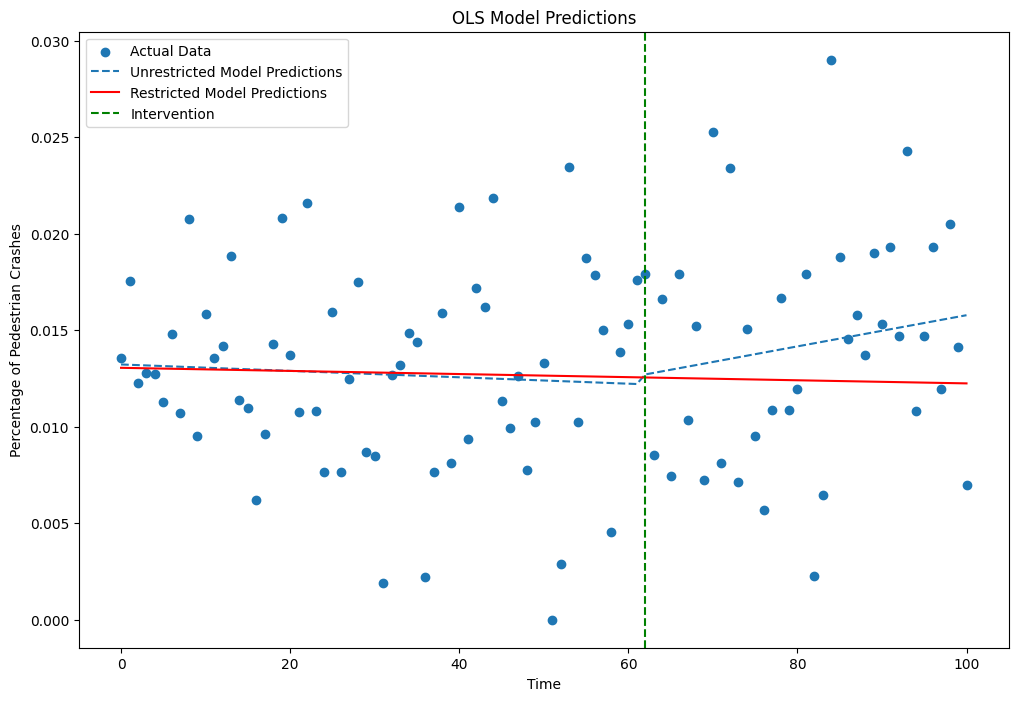

In [160]:
# ITS Analysis with OLS and P variable 

# Define the intervention point
start = 62

# Fit unrestricted OLS model
X_full = sm.add_constant(vb_incidents_per_month[['T', 'D', 'P']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

# Fit restricted OLS model (using data up to 'start' and only 'T')
X_restricted = sm.add_constant(vb_incidents_per_month.loc[:start, ['T']])
y_restricted = vb_incidents_per_month.loc[:start, 'percentage_pedestrian_crashes']
model_restricted = sm.OLS(y_restricted, X_restricted).fit()

# Making predictions from both models
vb_incidents_per_month['predictions_full'] = model_full.predict(X_full)

# Properly structure X for predictions from the restricted model over the full dataset
X_restricted_full = sm.add_constant(vb_incidents_per_month[['T']])  # including constant term
predictions_restricted = model_restricted.get_prediction(X_restricted_full)
summary_frame = predictions_restricted.summary_frame(alpha=0.05)

# Plotting the data and models
plt.figure(figsize=(12, 8))
plt.scatter(vb_incidents_per_month['T'], vb_incidents_per_month['percentage_pedestrian_crashes'], label='Actual Data')
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['predictions_full'], label='Unrestricted Model Predictions', linestyle='--')
plt.plot(vb_incidents_per_month['T'], summary_frame['mean'], label='Restricted Model Predictions', color='red')
# plt.fill_between(vb_incidents_per_month['T'], summary_frame['mean_ci_lower'], summary_frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI for Restricted Model')
plt.axvline(x=vb_incidents_per_month['T'][start], color='green', linestyle='--', label='Intervention')
plt.xlabel('Time')
plt.ylabel('Percentage of Pedestrian Crashes')
plt.title('OLS Model Predictions')
plt.legend()
plt.show()

In [95]:
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.031
Model:                                       OLS   Adj. R-squared:                  0.001
Method:                            Least Squares   F-statistic:                     1.048
Date:                           Thu, 15 Aug 2024   Prob (F-statistic):              0.375
Time:                                   10:07:56   Log-Likelihood:                 385.16
No. Observations:                            101   AIC:                            -762.3
Df Residuals:                                 97   BIC:                            -751.9
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.001      9.674      0.000       0.011       0.016
T          -1.661e-05   3.87e-05     -0.429      0.669   -9.34e-05    6.01e-05
D              0.0004      0.002      0.185      0.854      -0.004       0.005
P           9.742e-05   8.66e-05      1.124      0.264   -7.45e-05       0.000
==============================================================================
Omnibus:                        0.232   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.185
Skew:                           0.101   Prob(JB):                        0.912
Kurtosis:                       2.945   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

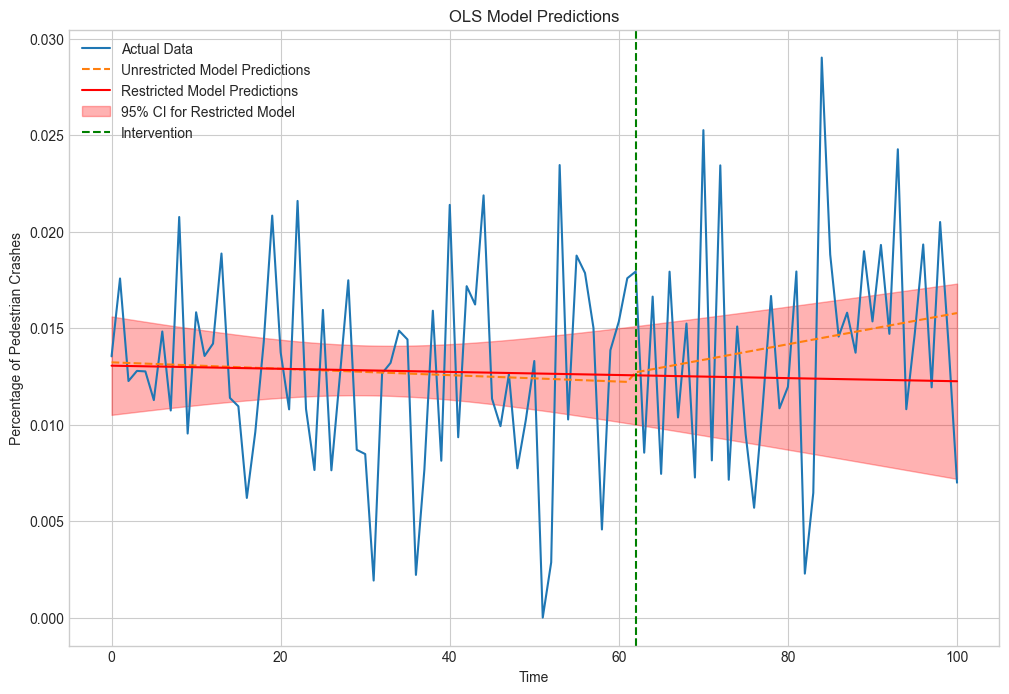

In [258]:
# ITS Analysis with OLS and P_prime variable

# Define the intervention point
start = 62

# Fit unrestricted OLS model
X_full = sm.add_constant(vb_incidents_per_month[['T', 'D', 'P_prime']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

# Fit restricted OLS model (using data up to 'start' and only 'T')
X_restricted = sm.add_constant(vb_incidents_per_month.loc[:start, ['T']])
y_restricted = vb_incidents_per_month.loc[:start, 'percentage_pedestrian_crashes']
model_restricted = sm.OLS(y_restricted, X_restricted).fit()

# Making predictions from both models
vb_incidents_per_month['predictions_full'] = model_full.predict(X_full)

# Properly structure X for predictions from the restricted model over the full dataset
X_restricted_full = sm.add_constant(vb_incidents_per_month[['T']])  # including constant term
predictions_restricted = model_restricted.get_prediction(X_restricted_full)
summary_frame = predictions_restricted.summary_frame(alpha=0.05)

# Plotting the data and models
plt.figure(figsize=(12, 8))
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['percentage_pedestrian_crashes'], label='Actual Data')
plt.plot(vb_incidents_per_month['T'], vb_incidents_per_month['predictions_full'], label='Unrestricted Model Predictions', linestyle='--')
plt.plot(vb_incidents_per_month['T'], summary_frame['mean'], label='Restricted Model Predictions', color='red')
plt.fill_between(vb_incidents_per_month['T'], summary_frame['mean_ci_lower'], summary_frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI for Restricted Model')
plt.axvline(x=vb_incidents_per_month['T'][start], color='green', linestyle='--', label='Intervention')
plt.xlabel('Time')
plt.ylabel('Percentage of Pedestrian Crashes')
plt.title('OLS Model Predictions')
plt.legend()
plt.show()

# Conclusion

In [264]:
start = 62

print(f"Virginia Beach Average percentage_pedestrian_crashes before intervention: {vb_incidents_per_month['percentage_pedestrian_crashes'][:start].mean()}")
print(f"Virginia Beach Average percentage_pedestrian_crashes after intervention: {vb_incidents_per_month['percentage_pedestrian_crashes'][start:].mean()}")
print(f"Virginia Beach Average percentage_pedestrian_crashes before intervention: {vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'][:start].mean()}")
print(f"Virginia Beach Average percentage_pedestrian_crashes after intervention: {vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'][start:].mean()}")

Virginia Beach Average percentage_pedestrian_crashes before intervention: 0.012722929479336908
Virginia Beach Average percentage_pedestrian_crashes after intervention: 0.014247382090374145
Virginia Beach Average percentage_pedestrian_crashes before intervention: 0.005266267635882028
Virginia Beach Average percentage_pedestrian_crashes after intervention: 0.0057049270141755


In [266]:
start = 120

print(f"Denver Average percentage_pedestrian_crashes before intervention: {denver_incidents_per_month['percentage_pedestrian_incidents'][:start].mean()}")
print(f"Denver Average percentage_pedestrian_crashes after intervention: {denver_incidents_per_month['percentage_pedestrian_incidents'][start:].mean()}")
print(f"Denver Average percentage_pedestrian_crashes before intervention: {denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'][:start].mean()}")
print(f"Denver Average percentage_pedestrian_crashes after intervention: {denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'][start:].mean()}")

Denver Average percentage_pedestrian_crashes before intervention: 0.022445642938893933
Denver Average percentage_pedestrian_crashes after intervention: 0.02860906690539464
Denver Average percentage_pedestrian_crashes before intervention: 0.010223497196499268
Denver Average percentage_pedestrian_crashes after intervention: 0.013241566902408857


In [97]:
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.031
Model:                                       OLS   Adj. R-squared:                  0.001
Method:                            Least Squares   F-statistic:                     1.048
Date:                           Thu, 15 Aug 2024   Prob (F-statistic):              0.375
Time:                                   10:08:02   Log-Likelihood:                 385.16
No. Observations:                            101   AIC:                            -762.3
Df Residuals:                                 97   BIC:                            -751.9
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.001      9.674      0.000       0.011       0.016
T          -1.661e-05   3.87e-05     -0.429      0.669   -9.34e-05    6.01e-05
D              0.0005      0.002      0.232      0.817      -0.004       0.005
P_prime     9.742e-05   8.66e-05      1.124      0.264   -7.45e-05       0.000
==============================================================================
Omnibus:                        0.232   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.185
Skew:                           0.101   Prob(JB):                        0.912
Kurtosis:                       2.945   Cond. No.                         247.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
model_restricted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.001
Model:                                       OLS   Adj. R-squared:                 -0.016
Method:                            Least Squares   F-statistic:                   0.05176
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):              0.821
Time:                                   13:38:33   Log-Likelihood:                 243.93
No. Observations:                             63   AIC:                            -483.9
Df Residuals:                                 61   BIC:                            -479.6
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.001     10.242      0.000       0.011       0.016
T           -8.07e-06   3.55e-05     -0.228      0.821    -7.9e-05    6.29e-05
==============================================================================
Omnibus:                        0.529   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.421
Skew:                          -0.196   Prob(JB):                        0.810
Kurtosis:                       2.916   Cond. No.                         71.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
X_full = sm.add_constant(vb_incidents_per_month[['D']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.019
Model:                                       OLS   Adj. R-squared:                  0.009
Method:                            Least Squares   F-statistic:                     1.887
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):              0.173
Time:                                   13:53:35   Log-Likelihood:                 384.51
No. Observations:                            101   AIC:                            -765.0
Df Residuals:                                 99   BIC:                            -759.8
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.001     18.452      0.000       0.011       0.014
D              0.0015      0.001      1.374      0.173      -0.001       0.004
==============================================================================
Omnibus:                        0.056   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.068
Skew:                           0.047   Prob(JB):                        0.966
Kurtosis:                       2.913   Cond. No.                         2.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
X_full = sm.add_constant(vb_incidents_per_month[['P']])
y_full = vb_incidents_per_month['percentage_pedestrian_crashes']
model_full = sm.OLS(y_full, X_full).fit()

model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_pedestrian_crashes   R-squared:                       0.030
Model:                                       OLS   Adj. R-squared:                  0.020
Method:                            Least Squares   F-statistic:                     3.013
Date:                           Wed, 14 Aug 2024   Prob (F-statistic):             0.0857
Time:                                   13:53:47   Log-Likelihood:                 385.07
No. Observations:                            101   AIC:                            -766.1
Df Residuals:                                 99   BIC:                            -760.9
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.001     19.890      0.000       0.011       0.014
P           7.778e-05   4.48e-05      1.736      0.086   -1.11e-05       0.000
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.075
Skew:                           0.064   Prob(JB):                        0.963
Kurtosis:                       2.964   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""